In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)
    # print("train IDs ", train_ids)
    # print("val IDs", val_ids)


    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):  
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_synthetic/mobilenetv2_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_synthetic/mobilenetv2_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")


FOLD 1/5
--------------------
Epoch 1: Loss 0.1471
Epoch 2: Loss 0.0408
Epoch 3: Loss 0.0334
Epoch 4: Loss 0.0206
Epoch 5: Loss 0.0334
Fold 1 Accuracy: 1.0000

FOLD 2/5
--------------------
Epoch 1: Loss 0.1534
Epoch 2: Loss 0.0417
Epoch 3: Loss 0.0360
Epoch 4: Loss 0.0212
Epoch 5: Loss 0.0272
Fold 2 Accuracy: 0.9973

FOLD 3/5
--------------------
Epoch 1: Loss 0.1513
Epoch 2: Loss 0.0412
Epoch 3: Loss 0.0275
Epoch 4: Loss 0.0179
Epoch 5: Loss 0.0213
Fold 3 Accuracy: 0.9945

FOLD 4/5
--------------------
Epoch 1: Loss 0.1586
Epoch 2: Loss 0.0483
Epoch 3: Loss 0.0287
Epoch 4: Loss 0.0227
Epoch 5: Loss 0.0260
Fold 4 Accuracy: 1.0000

FOLD 5/5
--------------------
Epoch 1: Loss 0.1364
Epoch 2: Loss 0.0424
Epoch 3: Loss 0.0360
Epoch 4: Loss 0.0198
Epoch 5: Loss 0.0154
Fold 5 Accuracy: 0.9945

Mean Accuracy across 5 folds: 0.9972
Best Accuracy observed: 1.0000
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_synthetic/mobilenetv2_img_best.

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="synthetic")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):  
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_synthetic/mobilenetv2_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_synthetic/mobilenetv2_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")


FOLD 1/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4994
Epoch 2: Loss 0.4261
Epoch 3: Loss 0.3859
Epoch 4: Loss 0.3356
Epoch 5: Loss 0.3263
Fold 1 Accuracy: 0.7280

FOLD 2/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4875
Epoch 2: Loss 0.4092
Epoch 3: Loss 0.3657
Epoch 4: Loss 0.3169
Epoch 5: Loss 0.3282
Fold 2 Accuracy: 0.7445

FOLD 3/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4868
Epoch 2: Loss 0.4006
Epoch 3: Loss 0.3643
Epoch 4: Loss 0.3167
Epoch 5: Loss 0.2877
Fold 3 Accuracy: 0.7335

FOLD 4/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4888
Epoch 2: Loss 0.3953
Epoch 3: Loss 0.3477
Epoch 4: Loss 0.3404
Epoch 5: Loss 0.2984
Fold 4 Accuracy: 0.7686

FOLD 5/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4777
Epoch 2: Loss 0.4151
Epoch 3: Loss 0.3610
Epoch 4: Loss 0.3268
Epoch 5: Loss 0.2980
Fold 5 Accuracy: 0.7906

Mean Accuracy across 5 folds: 0.7531
Best Accuracy observed: 0.7906
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/finetuned_synthetic/mobilenetv2_syn_best.pth


Lib+supermarket dataset

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)
    # print("train IDs ", train_ids)
    # print("val IDs", val_ids)


    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):  
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_imagenet/mobilenetv2_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_imagenet/mobilenetv2_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")


FOLD 1/5
--------------------
Epoch 1: Loss 0.1769
Epoch 2: Loss 0.0742
Epoch 3: Loss 0.0478
Epoch 4: Loss 0.0392
Epoch 5: Loss 0.0352
Fold 1 Accuracy: 0.9883

FOLD 2/5
--------------------
Epoch 1: Loss 0.1755
Epoch 2: Loss 0.0708
Epoch 3: Loss 0.0501
Epoch 4: Loss 0.0444
Epoch 5: Loss 0.0393
Fold 2 Accuracy: 0.9902

FOLD 3/5
--------------------
Epoch 1: Loss 0.1782
Epoch 2: Loss 0.0820
Epoch 3: Loss 0.0464
Epoch 4: Loss 0.0472
Epoch 5: Loss 0.0372
Fold 3 Accuracy: 0.9922

FOLD 4/5
--------------------
Epoch 1: Loss 0.1709
Epoch 2: Loss 0.0806
Epoch 3: Loss 0.0455
Epoch 4: Loss 0.0362
Epoch 5: Loss 0.0363
Fold 4 Accuracy: 0.9941

FOLD 5/5
--------------------
Epoch 1: Loss 0.1876
Epoch 2: Loss 0.0644
Epoch 3: Loss 0.0567
Epoch 4: Loss 0.0448
Epoch 5: Loss 0.0330
Fold 5 Accuracy: 0.9784

Mean Accuracy across 5 folds: 0.9886
Best Accuracy observed: 0.9941
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_imagenet/mobilenetv2

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)
    # print("train IDs ", train_ids)
    # print("val IDs", val_ids)


    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="synthetic")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):  
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_synthetic/mobilenetv2_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_synthetic/mobilenetv2_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")


FOLD 1/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4891
Epoch 2: Loss 0.4086
Epoch 3: Loss 0.3723
Epoch 4: Loss 0.3429
Epoch 5: Loss 0.3480
Fold 1 Accuracy: 0.7260

FOLD 2/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4908
Epoch 2: Loss 0.4185
Epoch 3: Loss 0.3880
Epoch 4: Loss 0.3768
Epoch 5: Loss 0.3489
Fold 2 Accuracy: 0.7436

FOLD 3/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4721
Epoch 2: Loss 0.3978
Epoch 3: Loss 0.3691
Epoch 4: Loss 0.3517
Epoch 5: Loss 0.3453
Fold 3 Accuracy: 0.7608

FOLD 4/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4885
Epoch 2: Loss 0.4028
Epoch 3: Loss 0.3804
Epoch 4: Loss 0.3581
Epoch 5: Loss 0.3428
Fold 4 Accuracy: 0.7314

FOLD 5/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4905
Epoch 2: Loss 0.4195
Epoch 3: Loss 0.3871
Epoch 4: Loss 0.3646
Epoch 5: Loss 0.3409
Fold 5 Accuracy: 0.7314

Mean Accuracy across 5 folds: 0.7386
Best Accuracy observed: 0.7608
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells/finetuned_synthetic/mobilenetv2_img_best.pth


#########LIB_SUPER_AUG############

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells_Aug/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)
    # print("train IDs ", train_ids)
    # print("val IDs", val_ids)


    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):  
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_imagenet/mobilenetv2_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_imagenet/mobilenetv2_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")


FOLD 1/5
--------------------
Epoch 1: Loss 0.1868
Epoch 2: Loss 0.0787
Epoch 3: Loss 0.0542
Epoch 4: Loss 0.0589
Epoch 5: Loss 0.0422
Fold 1 Accuracy: 0.9817

FOLD 2/5
--------------------
Epoch 1: Loss 0.1860
Epoch 2: Loss 0.0805
Epoch 3: Loss 0.0638
Epoch 4: Loss 0.0403
Epoch 5: Loss 0.0408
Fold 2 Accuracy: 0.9917

FOLD 3/5
--------------------
Epoch 1: Loss 0.1761
Epoch 2: Loss 0.0765
Epoch 3: Loss 0.0589
Epoch 4: Loss 0.0498
Epoch 5: Loss 0.0440
Fold 3 Accuracy: 0.9766

FOLD 4/5
--------------------
Epoch 1: Loss 0.1885
Epoch 2: Loss 0.0721
Epoch 3: Loss 0.0574
Epoch 4: Loss 0.0391
Epoch 5: Loss 0.0380
Fold 4 Accuracy: 0.9816

FOLD 5/5
--------------------
Epoch 1: Loss 0.1872
Epoch 2: Loss 0.0756
Epoch 3: Loss 0.0542
Epoch 4: Loss 0.0437
Epoch 5: Loss 0.0408
Fold 5 Accuracy: 0.9933

Mean Accuracy across 5 folds: 0.9850
Best Accuracy observed: 0.9933
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_imagenet/mobilen

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells_Aug/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)
    # print("train IDs ", train_ids)
    # print("val IDs", val_ids)


    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="synthetic")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training --------------------
    for epoch in range(5):  
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}")

    # -------------------- Validation --------------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    # Save best model weights so far
    if acc > best_acc:
        best_acc = acc
        best_model_wts = deepcopy(model.state_dict())

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_synthetic/mobilenetv2_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_synthetic/mobilenetv2_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")


FOLD 1/5
--------------------
Epoch 1: Loss 0.4950
Epoch 2: Loss 0.4274
Epoch 3: Loss 0.3907
Epoch 4: Loss 0.3646
Epoch 5: Loss 0.3533
Fold 1 Accuracy: 0.7133

FOLD 2/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4950
Epoch 2: Loss 0.4194
Epoch 3: Loss 0.3980
Epoch 4: Loss 0.3682
Epoch 5: Loss 0.3517
Fold 2 Accuracy: 0.7200

FOLD 3/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4911
Epoch 2: Loss 0.4189
Epoch 3: Loss 0.3925
Epoch 4: Loss 0.3722
Epoch 5: Loss 0.3583
Fold 3 Accuracy: 0.7446

FOLD 4/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.5046
Epoch 2: Loss 0.4292
Epoch 3: Loss 0.3879
Epoch 4: Loss 0.3704
Epoch 5: Loss 0.3449
Fold 4 Accuracy: 0.6962

FOLD 5/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss 0.4995
Epoch 2: Loss 0.4359
Epoch 3: Loss 0.3886
Epoch 4: Loss 0.3669
Epoch 5: Loss 0.3637
Fold 5 Accuracy: 0.7078

Mean Accuracy across 5 folds: 0.7164
Best Accuracy observed: 0.7446
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug/finetuned_synthetic/mobilenetv2_syn_best.pth


###TRAIN MB WITH EARLY STOPPING###

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells_Aug/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None

# --- Early stopping config ---
patience = 3   # number of epochs with no improvement
min_delta = 1e-4  # minimum change to qualify as improvement

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training with Early Stopping --------------------
    best_val_acc = 0.0
    epochs_no_improve = 0
    num_epochs = 30   # max epochs

    for epoch in range(num_epochs):  
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # --- Validation ---
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_acc = accuracy_score(y_true, y_pred)
        print(f"Epoch {epoch+1}: Train Loss {running_loss/len(train_loader):.4f}, Val Acc {val_acc:.4f}")

        # --- Early stopping check ---
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    # Save best model weights across folds
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_imagenet/mobilenetv2_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_imagenet/mobilenetv2_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")



FOLD 1/5
--------------------
Epoch 1: Train Loss 0.1824, Val Acc 0.9633
Epoch 2: Train Loss 0.0725, Val Acc 0.9717
Epoch 3: Train Loss 0.0540, Val Acc 0.9683
Epoch 4: Train Loss 0.0465, Val Acc 0.9900
Epoch 5: Train Loss 0.0544, Val Acc 0.9883
Epoch 6: Train Loss 0.0427, Val Acc 0.9883
Epoch 7: Train Loss 0.0321, Val Acc 0.9933
Epoch 8: Train Loss 0.0270, Val Acc 0.9900
Epoch 9: Train Loss 0.0265, Val Acc 0.9917
Epoch 10: Train Loss 0.0258, Val Acc 0.9883
Early stopping at epoch 10
Fold 1 Best Val Accuracy: 0.9933

FOLD 2/5
--------------------
Epoch 1: Train Loss 0.1996, Val Acc 0.9567
Epoch 2: Train Loss 0.0730, Val Acc 0.9800
Epoch 3: Train Loss 0.0765, Val Acc 0.9850
Epoch 4: Train Loss 0.0563, Val Acc 0.9900
Epoch 5: Train Loss 0.0427, Val Acc 0.9900
Epoch 6: Train Loss 0.0373, Val Acc 0.9967
Epoch 7: Train Loss 0.0296, Val Acc 0.9967
Epoch 8: Train Loss 0.0332, Val Acc 0.9950
Epoch 9: Train Loss 0.0253, Val Acc 0.9950
Early stopping at epoch 9
Fold 2 Best Val Accuracy: 0.9967




FOLD 1/5
--------------------
Epoch 1: Train Loss 0.1890, Train Acc 0.8160, Val Loss 0.0638, Val Acc 0.9450
Epoch 2: Train Loss 0.0790, Train Acc 0.9249, Val Loss 0.0282, Val Acc 0.9800
Epoch 3: Train Loss 0.0540, Train Acc 0.9504, Val Loss 0.0256, Val Acc 0.9783
Epoch 4: Train Loss 0.0465, Train Acc 0.9537, Val Loss 0.0169, Val Acc 0.9833
Epoch 5: Train Loss 0.0395, Train Acc 0.9583, Val Loss 0.0182, Val Acc 0.9833
Epoch 6: Train Loss 0.0321, Train Acc 0.9679, Val Loss 0.0212, Val Acc 0.9867
Epoch 7: Train Loss 0.0318, Train Acc 0.9687, Val Loss 0.0095, Val Acc 0.9933
Epoch 8: Train Loss 0.0238, Train Acc 0.9783, Val Loss 0.0063, Val Acc 0.9967
Epoch 9: Train Loss 0.0265, Train Acc 0.9758, Val Loss 0.0069, Val Acc 0.9950
Epoch 10: Train Loss 0.0299, Train Acc 0.9737, Val Loss 0.0093, Val Acc 0.9900
Epoch 11: Train Loss 0.0287, Train Acc 0.9754, Val Loss 0.0120, Val Acc 0.9900
Early stopping at epoch 11
Fold 1 Best Val Accuracy: 0.9967

FOLD 2/5
--------------------
Epoch 1: Train Los

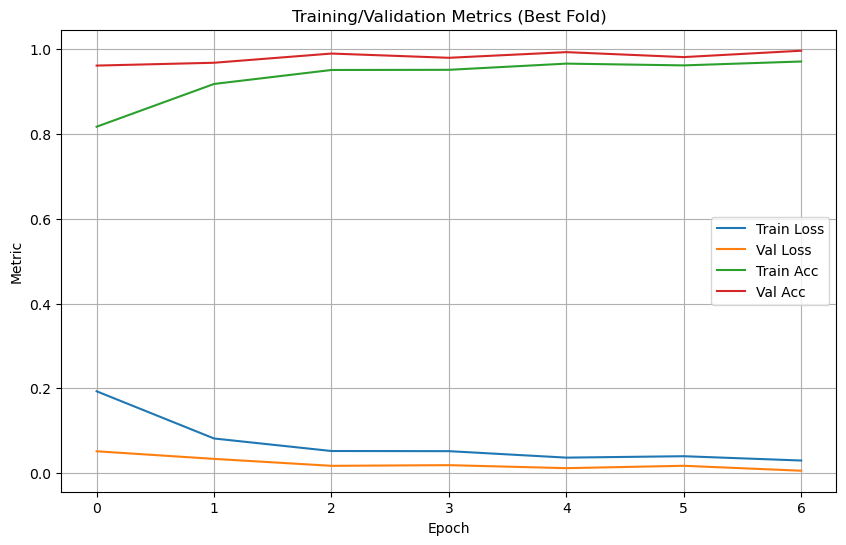

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells_Aug/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None   # track history for the best fold

# --- Early stopping config ---
patience = 3   # number of epochs with no improvement
min_delta = 1e-4  # minimum change to qualify as improvement

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training with Early Stopping --------------------
    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30   # max epochs

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):  
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # --- Validation ---
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        # Save to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # --- Early stopping check ---
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)   # save history for this fold
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    # Save best model weights across folds
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_imagenet/mobilenetv2_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_imagenet/mobilenetv2_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")

# -------------------- Plot Best Fold History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold)")
plt.legend()
plt.grid(True)
plt.show()



FOLD 1/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.4893, Train Acc 0.4910, Val Loss 0.4217, Val Acc 0.5800
Epoch 2: Train Loss 0.4208, Train Acc 0.5732, Val Loss 0.4068, Val Acc 0.5933
Epoch 3: Train Loss 0.3942, Train Acc 0.6020, Val Loss 0.3453, Val Acc 0.6583
Epoch 4: Train Loss 0.3613, Train Acc 0.6508, Val Loss 0.2995, Val Acc 0.7100
Epoch 5: Train Loss 0.3383, Train Acc 0.6729, Val Loss 0.3047, Val Acc 0.7367
Epoch 6: Train Loss 0.3319, Train Acc 0.6767, Val Loss 0.3185, Val Acc 0.6917
Epoch 7: Train Loss 0.3283, Train Acc 0.6854, Val Loss 0.3543, Val Acc 0.6500
Epoch 8: Train Loss 0.3303, Train Acc 0.6963, Val Loss 0.2745, Val Acc 0.7383
Epoch 9: Train Loss 0.3220, Train Acc 0.6721, Val Loss 0.2687, Val Acc 0.7317
Epoch 10: Train Loss 0.3064, Train Acc 0.6904, Val Loss 0.2630, Val Acc 0.7417
Epoch 11: Train Loss 0.3046, Train Acc 0.7055, Val Loss 0.2351, Val Acc 0.7900
Epoch 12: Train Loss 0.2855, Train Acc 0.7163, Val Loss 0.2373, Val Acc 0.7733
Epoch 13: Train Loss 0.2972, Train Acc 0.7038, Val Loss 0.244

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.4920, Train Acc 0.4764, Val Loss 0.3953, Val Acc 0.5767
Epoch 2: Train Loss 0.4284, Train Acc 0.5511, Val Loss 0.3616, Val Acc 0.6583
Epoch 3: Train Loss 0.3826, Train Acc 0.6016, Val Loss 0.3279, Val Acc 0.6767
Epoch 4: Train Loss 0.3642, Train Acc 0.6237, Val Loss 0.2828, Val Acc 0.7550
Epoch 5: Train Loss 0.3421, Train Acc 0.6592, Val Loss 0.2785, Val Acc 0.7350
Epoch 6: Train Loss 0.3391, Train Acc 0.6604, Val Loss 0.3019, Val Acc 0.6933
Epoch 7: Train Loss 0.3367, Train Acc 0.6696, Val Loss 0.2758, Val Acc 0.7300
Early stopping at epoch 7
Fold 2 Best Val Accuracy: 0.7550

FOLD 3/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.4948, Train Acc 0.4775, Val Loss 0.3845, Val Acc 0.6244
Epoch 2: Train Loss 0.4146, Train Acc 0.5826, Val Loss 0.3358, Val Acc 0.6895
Epoch 3: Train Loss 0.3973, Train Acc 0.6022, Val Loss 0.3165, Val Acc 0.6978
Epoch 4: Train Loss 0.3740, Train Acc 0.6163, Val Loss 0.3140, Val Acc 0.6895
Epoch 5: Train Loss 0.3307, Train Acc 0.6681, Val Loss 0.3041, Val Acc 0.7312
Epoch 6: Train Loss 0.3418, Train Acc 0.6706, Val Loss 0.2954, Val Acc 0.7195
Epoch 7: Train Loss 0.3292, Train Acc 0.6751, Val Loss 0.2655, Val Acc 0.7696
Epoch 8: Train Loss 0.3187, Train Acc 0.6864, Val Loss 0.2434, Val Acc 0.7613
Epoch 9: Train Loss 0.3026, Train Acc 0.6952, Val Loss 0.2616, Val Acc 0.7646
Epoch 10: Train Loss 0.3145, Train Acc 0.6864, Val Loss 0.2353, Val Acc 0.7746
Epoch 11: Train Loss 0.3033, Train Acc 0.6927, Val Loss 0.2264, Val Acc 0.7813
Epoch 12: Train Loss 0.2865, Train Acc 0.7131, Val Loss 0.2532, Val Acc 0.7646
Epoch 13: Train Loss 0.2925, Train Acc 0.7198, Val Loss 0.216

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.4846, Train Acc 0.4908, Val Loss 0.4245, Val Acc 0.5392
Epoch 2: Train Loss 0.4185, Train Acc 0.5780, Val Loss 0.3916, Val Acc 0.6294
Epoch 3: Train Loss 0.3972, Train Acc 0.5988, Val Loss 0.3618, Val Acc 0.6644
Epoch 4: Train Loss 0.3737, Train Acc 0.6309, Val Loss 0.3218, Val Acc 0.6761
Epoch 5: Train Loss 0.3533, Train Acc 0.6580, Val Loss 0.2966, Val Acc 0.7028
Epoch 6: Train Loss 0.3438, Train Acc 0.6618, Val Loss 0.3012, Val Acc 0.6995
Epoch 7: Train Loss 0.3259, Train Acc 0.6864, Val Loss 0.3098, Val Acc 0.7195
Epoch 8: Train Loss 0.3203, Train Acc 0.6889, Val Loss 0.2909, Val Acc 0.7362
Epoch 9: Train Loss 0.3116, Train Acc 0.6877, Val Loss 0.2661, Val Acc 0.7295
Epoch 10: Train Loss 0.3111, Train Acc 0.6977, Val Loss 0.2621, Val Acc 0.7429
Epoch 11: Train Loss 0.2915, Train Acc 0.7181, Val Loss 0.2825, Val Acc 0.7346
Epoch 12: Train Loss 0.2993, Train Acc 0.6997, Val Loss 0.2769, Val Acc 0.7279
Epoch 13: Train Loss 0.2995, Train Acc 0.7118, Val Loss 0.240

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.4890, Train Acc 0.4733, Val Loss 0.3668, Val Acc 0.6361
Epoch 2: Train Loss 0.4239, Train Acc 0.5621, Val Loss 0.3739, Val Acc 0.6260
Epoch 3: Train Loss 0.3875, Train Acc 0.6126, Val Loss 0.3481, Val Acc 0.6661
Epoch 4: Train Loss 0.3687, Train Acc 0.6222, Val Loss 0.2918, Val Acc 0.7346
Epoch 5: Train Loss 0.3498, Train Acc 0.6414, Val Loss 0.3063, Val Acc 0.7062
Epoch 6: Train Loss 0.3422, Train Acc 0.6522, Val Loss 0.2600, Val Acc 0.7362
Epoch 7: Train Loss 0.3147, Train Acc 0.6931, Val Loss 0.2522, Val Acc 0.7629
Epoch 8: Train Loss 0.3238, Train Acc 0.6726, Val Loss 0.2637, Val Acc 0.7429
Epoch 9: Train Loss 0.3032, Train Acc 0.6935, Val Loss 0.2349, Val Acc 0.7613
Epoch 10: Train Loss 0.3103, Train Acc 0.7010, Val Loss 0.2545, Val Acc 0.7362
Early stopping at epoch 10
Fold 5 Best Val Accuracy: 0.7629

Mean Accuracy across 5 folds: 0.7788
Best Accuracy observed: 0.8013
Best model saved to /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/

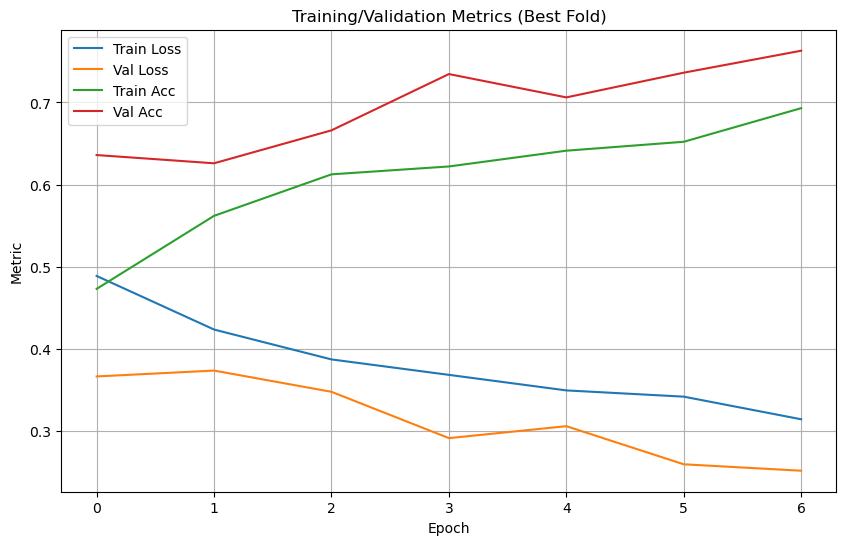

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_Keells_Aug/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None   # track history for the best fold

# --- Early stopping config ---
patience = 3   # number of epochs with no improvement
min_delta = 1e-4  # minimum change to qualify as improvement

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="synthetic")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training with Early Stopping --------------------
    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30   # max epochs

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):  
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # --- Validation ---
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        # Save to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # --- Early stopping check ---
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)   # save history for this fold
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    # Save best model weights across folds
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_synthetic/mobilenetv2_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/lib_keells_aug_es/finetuned_synthetic/mobilenetv2_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")

# -------------------- Plot Best Fold History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold)")
plt.legend()
plt.grid(True)
plt.show()



FOLD 1/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5211, Train Acc 0.4330, Val Loss 0.4681, Val Acc 0.5420
Epoch 2: Train Loss 0.4322, Train Acc 0.5358, Val Loss 0.3471, Val Acc 0.6361
Epoch 3: Train Loss 0.3910, Train Acc 0.5956, Val Loss 0.3227, Val Acc 0.6934
Epoch 4: Train Loss 0.3603, Train Acc 0.6344, Val Loss 0.3041, Val Acc 0.6959
Epoch 5: Train Loss 0.3474, Train Acc 0.6430, Val Loss 0.2946, Val Acc 0.7417
Epoch 6: Train Loss 0.3262, Train Acc 0.6755, Val Loss 0.2725, Val Acc 0.7557
Epoch 7: Train Loss 0.3072, Train Acc 0.6942, Val Loss 0.2838, Val Acc 0.7354
Epoch 8: Train Loss 0.3050, Train Acc 0.6802, Val Loss 0.2764, Val Acc 0.7354
Epoch 9: Train Loss 0.3099, Train Acc 0.6847, Val Loss 0.2269, Val Acc 0.7824
Epoch 10: Train Loss 0.3083, Train Acc 0.6841, Val Loss 0.2250, Val Acc 0.8015
Epoch 11: Train Loss 0.2998, Train Acc 0.6914, Val Loss 0.2182, Val Acc 0.7990
Epoch 12: Train Loss 0.2805, Train Acc 0.7156, Val Loss 0.2384, Val Acc 0.7913
Epoch 13: Train Loss 0.2781, Train Acc 0.7171, Val Loss 0.250

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5122, Train Acc 0.4486, Val Loss 0.3940, Val Acc 0.6043
Epoch 2: Train Loss 0.4212, Train Acc 0.5552, Val Loss 0.3496, Val Acc 0.6336
Epoch 3: Train Loss 0.3795, Train Acc 0.6115, Val Loss 0.3057, Val Acc 0.6807
Epoch 4: Train Loss 0.3746, Train Acc 0.6198, Val Loss 0.3169, Val Acc 0.6705
Epoch 5: Train Loss 0.3359, Train Acc 0.6564, Val Loss 0.2887, Val Acc 0.6972
Epoch 6: Train Loss 0.3400, Train Acc 0.6487, Val Loss 0.2829, Val Acc 0.7341
Epoch 7: Train Loss 0.3267, Train Acc 0.6688, Val Loss 0.2625, Val Acc 0.7341
Epoch 8: Train Loss 0.3159, Train Acc 0.6901, Val Loss 0.2520, Val Acc 0.7595
Epoch 9: Train Loss 0.3054, Train Acc 0.7000, Val Loss 0.2582, Val Acc 0.7392
Epoch 10: Train Loss 0.2865, Train Acc 0.7086, Val Loss 0.2395, Val Acc 0.7710
Epoch 11: Train Loss 0.2983, Train Acc 0.6892, Val Loss 0.2082, Val Acc 0.7964
Epoch 12: Train Loss 0.2844, Train Acc 0.7079, Val Loss 0.2248, Val Acc 0.7621
Epoch 13: Train Loss 0.2887, Train Acc 0.7111, Val Loss 0.181

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5174, Train Acc 0.4400, Val Loss 0.4176, Val Acc 0.5483
Epoch 2: Train Loss 0.4288, Train Acc 0.5409, Val Loss 0.3675, Val Acc 0.6260
Epoch 3: Train Loss 0.3778, Train Acc 0.6109, Val Loss 0.3125, Val Acc 0.6807
Epoch 4: Train Loss 0.3644, Train Acc 0.6172, Val Loss 0.2978, Val Acc 0.7048
Epoch 5: Train Loss 0.3427, Train Acc 0.6481, Val Loss 0.2879, Val Acc 0.7366
Epoch 6: Train Loss 0.3314, Train Acc 0.6545, Val Loss 0.2952, Val Acc 0.7099
Epoch 7: Train Loss 0.3107, Train Acc 0.6688, Val Loss 0.2559, Val Acc 0.7532
Epoch 8: Train Loss 0.3036, Train Acc 0.6911, Val Loss 0.2828, Val Acc 0.7125
Epoch 9: Train Loss 0.2945, Train Acc 0.6949, Val Loss 0.2446, Val Acc 0.7646
Epoch 10: Train Loss 0.3086, Train Acc 0.6844, Val Loss 0.2594, Val Acc 0.7494
Epoch 11: Train Loss 0.2951, Train Acc 0.6923, Val Loss 0.2673, Val Acc 0.7417
Epoch 12: Train Loss 0.2837, Train Acc 0.7089, Val Loss 0.2105, Val Acc 0.7837
Epoch 13: Train Loss 0.2817, Train Acc 0.7117, Val Loss 0.212

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5242, Train Acc 0.4324, Val Loss 0.3959, Val Acc 0.6018
Epoch 2: Train Loss 0.4254, Train Acc 0.5485, Val Loss 0.3442, Val Acc 0.6616
Epoch 3: Train Loss 0.3831, Train Acc 0.6071, Val Loss 0.3058, Val Acc 0.6921
Epoch 4: Train Loss 0.3648, Train Acc 0.6242, Val Loss 0.3122, Val Acc 0.6578
Epoch 5: Train Loss 0.3346, Train Acc 0.6535, Val Loss 0.2958, Val Acc 0.6997
Epoch 6: Train Loss 0.3339, Train Acc 0.6580, Val Loss 0.2718, Val Acc 0.7188
Epoch 7: Train Loss 0.3144, Train Acc 0.6701, Val Loss 0.2563, Val Acc 0.7532
Epoch 8: Train Loss 0.3073, Train Acc 0.6911, Val Loss 0.2368, Val Acc 0.7723
Epoch 9: Train Loss 0.3093, Train Acc 0.6774, Val Loss 0.2548, Val Acc 0.7557
Epoch 10: Train Loss 0.2956, Train Acc 0.7016, Val Loss 0.2102, Val Acc 0.7964
Epoch 11: Train Loss 0.2847, Train Acc 0.7098, Val Loss 0.2454, Val Acc 0.7672
Epoch 12: Train Loss 0.2903, Train Acc 0.7000, Val Loss 0.2151, Val Acc 0.7583
Epoch 13: Train Loss 0.2846, Train Acc 0.7136, Val Loss 0.194

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5211, Train Acc 0.4427, Val Loss 0.3946, Val Acc 0.5949
Epoch 2: Train Loss 0.4269, Train Acc 0.5442, Val Loss 0.3604, Val Acc 0.6076
Epoch 3: Train Loss 0.3889, Train Acc 0.5843, Val Loss 0.3397, Val Acc 0.6280
Epoch 4: Train Loss 0.3738, Train Acc 0.6062, Val Loss 0.2861, Val Acc 0.6981
Epoch 5: Train Loss 0.3490, Train Acc 0.6377, Val Loss 0.3047, Val Acc 0.7019
Epoch 6: Train Loss 0.3253, Train Acc 0.6613, Val Loss 0.2814, Val Acc 0.7070
Epoch 7: Train Loss 0.3124, Train Acc 0.6810, Val Loss 0.2494, Val Acc 0.7529
Epoch 8: Train Loss 0.3134, Train Acc 0.6759, Val Loss 0.2494, Val Acc 0.7350
Epoch 9: Train Loss 0.3042, Train Acc 0.6915, Val Loss 0.2347, Val Acc 0.7554
Epoch 10: Train Loss 0.2966, Train Acc 0.6947, Val Loss 0.2285, Val Acc 0.7554
Epoch 11: Train Loss 0.2776, Train Acc 0.7179, Val Loss 0.2122, Val Acc 0.8051
Epoch 12: Train Loss 0.2862, Train Acc 0.6975, Val Loss 0.2164, Val Acc 0.7936
Epoch 13: Train Loss 0.2702, Train Acc 0.7271, Val Loss 0.201

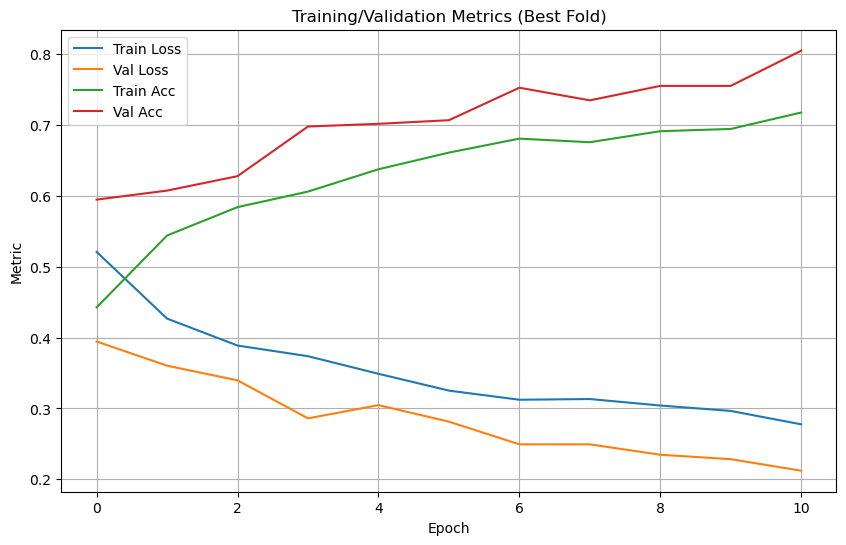

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "//home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_keells_Aug_left_right/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None   # track history for the best fold

# --- Early stopping config ---
patience = 3   # number of epochs with no improvement
min_delta = 1e-4  # minimum change to qualify as improvement

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="synthetic")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training with Early Stopping --------------------
    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30   # max epochs

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):  
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # --- Validation ---
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        # Save to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # --- Early stopping check ---
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)   # save history for this fold
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    # Save best model weights across folds
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/syn/mobilenetv2_syn_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/syn/mobilenetv2_syn_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")

# -------------------- Plot final Fold History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold)")
plt.legend()
plt.grid(True)
plt.show()



FOLD 1/5
--------------------
Epoch 1: Train Loss 0.1451, Train Acc 0.8705, Val Loss 0.0298, Val Acc 0.9809
Epoch 2: Train Loss 0.0574, Train Acc 0.9475, Val Loss 0.0170, Val Acc 0.9847
Epoch 3: Train Loss 0.0463, Train Acc 0.9558, Val Loss 0.0133, Val Acc 0.9911
Epoch 4: Train Loss 0.0371, Train Acc 0.9644, Val Loss 0.0081, Val Acc 0.9949
Epoch 5: Train Loss 0.0418, Train Acc 0.9593, Val Loss 0.0070, Val Acc 0.9975
Epoch 6: Train Loss 0.0247, Train Acc 0.9749, Val Loss 0.0044, Val Acc 0.9949
Epoch 7: Train Loss 0.0204, Train Acc 0.9809, Val Loss 0.0030, Val Acc 0.9987
Epoch 8: Train Loss 0.0229, Train Acc 0.9790, Val Loss 0.0049, Val Acc 0.9962
Epoch 9: Train Loss 0.0223, Train Acc 0.9758, Val Loss 0.0057, Val Acc 0.9936
Epoch 10: Train Loss 0.0176, Train Acc 0.9812, Val Loss 0.0022, Val Acc 0.9987
Early stopping at epoch 10
Fold 1 Best Val Accuracy: 0.9987

FOLD 2/5
--------------------
Epoch 1: Train Loss 0.1517, Train Acc 0.8479, Val Loss 0.0278, Val Acc 0.9835
Epoch 2: Train Loss

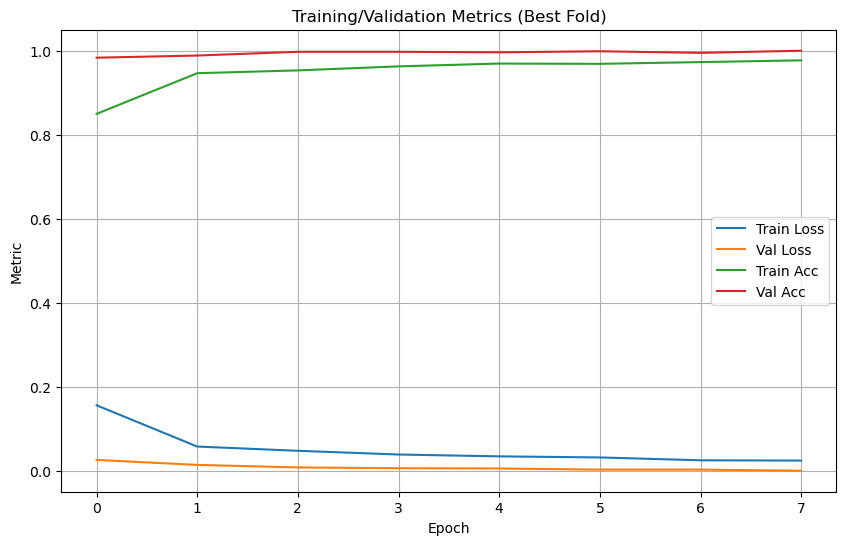

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append(os.path.join(sub_path,fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        
        return img, label

# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "//home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_keells_Aug_left_right/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")  

    elif pretrained == "synthetic":
        # create same architecture
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model

# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None   # track history for the best fold

# --- Early stopping config ---
patience = 3   # number of epochs with no improvement
min_delta = 1e-4  # minimum change to qualify as improvement

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-"*20)

    train_sub = Subset(dataset, train_ids)
    val_sub   = Subset(dataset, val_ids)
    
    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_sub, batch_size=16)
   
    model = get_model(pretrained="imagenet")   # or "synthetic"
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # -------------------- Training with Early Stopping --------------------
    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30   # max epochs

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):  
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # --- Validation ---
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        # Save to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # --- Early stopping check ---
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)   # save history for this fold
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    # Save best model weights across folds
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/img/mobilenetv2_img_best.pth"
save_path_old = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/img/mobilenetv2_img_old.pth"
torch.save(best_model_wts, save_path)
torch.save(best_model_wts, save_path_old, _use_new_zipfile_serialization=False)
print(f"Best model saved to {save_path}")

# -------------------- Plot final Fold History --------------------
plt.figure(figsize=(10,6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold)")
plt.legend()
plt.grid(True)
plt.show()


SESSION 2 img weights


FOLD 1/5
--------------------
Epoch 1: Train Loss 0.1601, Train Acc 0.8578, Val Loss 0.0431, Val Acc 0.9682
Epoch 2: Train Loss 0.0644, Train Acc 0.9376, Val Loss 0.0240, Val Acc 0.9809
Epoch 3: Train Loss 0.0495, Train Acc 0.9535, Val Loss 0.0127, Val Acc 0.9885
Epoch 4: Train Loss 0.0369, Train Acc 0.9669, Val Loss 0.0104, Val Acc 0.9962
Epoch 5: Train Loss 0.0329, Train Acc 0.9669, Val Loss 0.0087, Val Acc 0.9911
Epoch 6: Train Loss 0.0291, Train Acc 0.9714, Val Loss 0.0053, Val Acc 0.9975
Epoch 7: Train Loss 0.0281, Train Acc 0.9717, Val Loss 0.0081, Val Acc 0.9911
Epoch 8: Train Loss 0.0290, Train Acc 0.9733, Val Loss 0.0024, Val Acc 1.0000
Epoch 9: Train Loss 0.0221, Train Acc 0.9771, Val Loss 0.0025, Val Acc 1.0000
Epoch 10: Train Loss 0.0243, Train Acc 0.9777, Val Loss 0.0054, Val Acc 0.9962
Epoch 11: Train Loss 0.0204, Train Acc 0.9800, Val Loss 0.0041, Val Acc 0.9975
Early stopping at epoch 11
Fold 1 Best Val Accuracy: 1.0000
 Saved best model for Fold 1 at: /home/intellisen

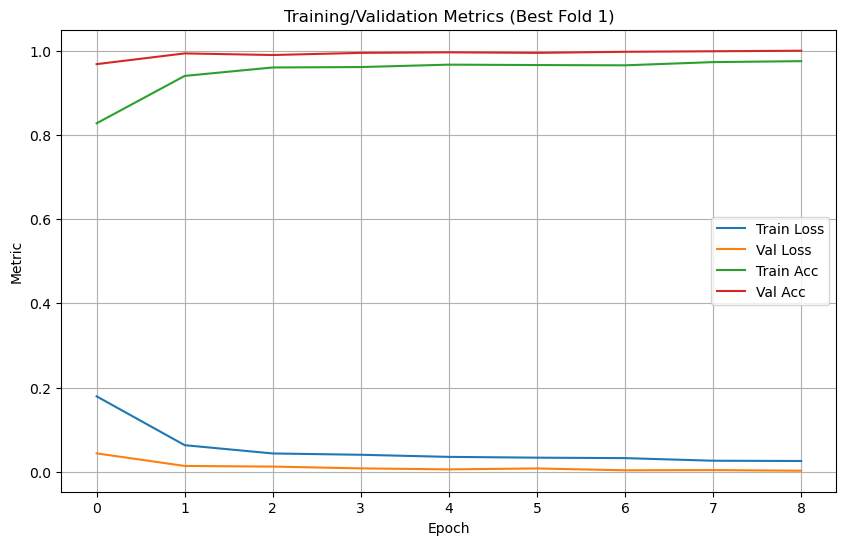

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("RGB")  # convert to 3-channel RGB
        if self.transform:
            img = self.transform(img)

        return img, label


# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_keells_Aug_left_right/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="imagenet"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")
    elif pretrained == "synthetic":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model


# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None
best_fold_idx = None  # <<< --- track best fold index --- >>>

# Early stopping config
patience = 3
min_delta = 1e-4

save_root = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/session2/img/mb"  # <<< --- base path --- >>>
os.makedirs(save_root, exist_ok=True)

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold + 1}/{k_folds}")
    print("-" * 20)

    train_sub = Subset(dataset, train_ids)
    val_sub = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="imagenet")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # Validation
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch + 1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Early stopping
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold + 1} Best Val Accuracy: {best_val_acc:.4f}")

    # <<< --- save each fold model --- >>>
    fold_dir = os.path.join(save_root, f"fold_{fold + 1}")
    os.makedirs(fold_dir, exist_ok=True)
    fold_model_path = os.path.join(fold_dir, f"mobilenetv2_fold{fold + 1}_best.pth")
    torch.save(best_fold_wts, fold_model_path)
    print(f" Saved best model for Fold {fold + 1} at: {fold_model_path}")

    # track best overall fold
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)
        best_fold_history = deepcopy(history)
        best_fold_idx = fold + 1

# -------------------- Summary --------------------
print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f} (Fold {best_fold_idx})")

# <<< --- Save best overall model --- >>>
best_model_path = os.path.join(save_root, f"mobilenetv2_best_overall_fold{best_fold_idx}.pth")
torch.save(best_model_wts, best_model_path)
print(f" Best overall model saved to: {best_model_path}")

# -------------------- Plot final Fold History --------------------
plt.figure(figsize=(10, 6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title(f"Training/Validation Metrics (Best Fold {best_fold_idx})")
plt.legend()
plt.grid(True)
plt.show()


SESSION 2 SYN WEIGHTS


FOLD 1/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5299, Train Acc 0.4190, Val Loss 0.4552, Val Acc 0.5458
Epoch 2: Train Loss 0.4361, Train Acc 0.5278, Val Loss 0.3631, Val Acc 0.6527
Epoch 3: Train Loss 0.3863, Train Acc 0.5912, Val Loss 0.3224, Val Acc 0.6896
Epoch 4: Train Loss 0.3665, Train Acc 0.6141, Val Loss 0.2840, Val Acc 0.7328
Epoch 5: Train Loss 0.3535, Train Acc 0.6293, Val Loss 0.2741, Val Acc 0.7430
Epoch 6: Train Loss 0.3184, Train Acc 0.6739, Val Loss 0.2424, Val Acc 0.7812
Epoch 7: Train Loss 0.3109, Train Acc 0.6841, Val Loss 0.3015, Val Acc 0.7265
Epoch 8: Train Loss 0.3200, Train Acc 0.6713, Val Loss 0.2385, Val Acc 0.7659
Epoch 9: Train Loss 0.3010, Train Acc 0.6895, Val Loss 0.2917, Val Acc 0.7519
Early stopping at epoch 9
Fold 1 Best Val Accuracy: 0.7812
 Saved best model for Fold 1 at: /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/session2/syn/mb/fold_1/mobilenetv2_fold1_best.pth

FOLD 2/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5261, Train Acc 0.4362, Val Loss 0.4060, Val Acc 0.5407
Epoch 2: Train Loss 0.4328, Train Acc 0.5428, Val Loss 0.3538, Val Acc 0.6527
Epoch 3: Train Loss 0.3991, Train Acc 0.5829, Val Loss 0.3127, Val Acc 0.6603
Epoch 4: Train Loss 0.3683, Train Acc 0.6160, Val Loss 0.2752, Val Acc 0.7176
Epoch 5: Train Loss 0.3477, Train Acc 0.6443, Val Loss 0.2600, Val Acc 0.7265
Epoch 6: Train Loss 0.3294, Train Acc 0.6634, Val Loss 0.2604, Val Acc 0.7252
Epoch 7: Train Loss 0.3284, Train Acc 0.6682, Val Loss 0.2364, Val Acc 0.7659
Epoch 8: Train Loss 0.3124, Train Acc 0.6780, Val Loss 0.2294, Val Acc 0.7659
Epoch 9: Train Loss 0.3109, Train Acc 0.6787, Val Loss 0.2300, Val Acc 0.7595
Epoch 10: Train Loss 0.2998, Train Acc 0.7031, Val Loss 0.2135, Val Acc 0.7774
Epoch 11: Train Loss 0.3005, Train Acc 0.7057, Val Loss 0.2262, Val Acc 0.7761
Epoch 12: Train Loss 0.2744, Train Acc 0.7238, Val Loss 0.1874, Val Acc 0.8206
Epoch 13: Train Loss 0.2818, Train Acc 0.7175, Val Loss 0.204

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5166, Train Acc 0.4451, Val Loss 0.4342, Val Acc 0.5522
Epoch 2: Train Loss 0.4317, Train Acc 0.5409, Val Loss 0.3569, Val Acc 0.6399
Epoch 3: Train Loss 0.3835, Train Acc 0.6017, Val Loss 0.3239, Val Acc 0.6870
Epoch 4: Train Loss 0.3583, Train Acc 0.6230, Val Loss 0.3062, Val Acc 0.6718
Epoch 5: Train Loss 0.3450, Train Acc 0.6316, Val Loss 0.2968, Val Acc 0.6997
Epoch 6: Train Loss 0.3260, Train Acc 0.6564, Val Loss 0.2863, Val Acc 0.7443
Epoch 7: Train Loss 0.3166, Train Acc 0.6755, Val Loss 0.2607, Val Acc 0.7430
Epoch 8: Train Loss 0.3159, Train Acc 0.6666, Val Loss 0.2602, Val Acc 0.7405
Epoch 9: Train Loss 0.3031, Train Acc 0.6876, Val Loss 0.2705, Val Acc 0.7252
Early stopping at epoch 9
Fold 3 Best Val Accuracy: 0.7443
 Saved best model for Fold 3 at: /home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/session2/syn/mb/fold_3/mobilenetv2_fold3_best.pth

FOLD 4/5
--------------------


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5267, Train Acc 0.4248, Val Loss 0.3988, Val Acc 0.5636
Epoch 2: Train Loss 0.4278, Train Acc 0.5285, Val Loss 0.3849, Val Acc 0.6221
Epoch 3: Train Loss 0.3841, Train Acc 0.5950, Val Loss 0.3223, Val Acc 0.6361
Epoch 4: Train Loss 0.3635, Train Acc 0.6300, Val Loss 0.2892, Val Acc 0.7023
Epoch 5: Train Loss 0.3468, Train Acc 0.6373, Val Loss 0.2723, Val Acc 0.7150
Epoch 6: Train Loss 0.3307, Train Acc 0.6605, Val Loss 0.2567, Val Acc 0.7481
Epoch 7: Train Loss 0.3395, Train Acc 0.6478, Val Loss 0.2655, Val Acc 0.7405
Epoch 8: Train Loss 0.3139, Train Acc 0.6774, Val Loss 0.2418, Val Acc 0.7621
Epoch 9: Train Loss 0.3014, Train Acc 0.6965, Val Loss 0.2612, Val Acc 0.7392
Epoch 10: Train Loss 0.2946, Train Acc 0.6971, Val Loss 0.2159, Val Acc 0.7774
Epoch 11: Train Loss 0.2859, Train Acc 0.7130, Val Loss 0.2072, Val Acc 0.7824
Epoch 12: Train Loss 0.2730, Train Acc 0.7356, Val Loss 0.2198, Val Acc 0.7901
Epoch 13: Train Loss 0.2851, Train Acc 0.7076, Val Loss 0.221

/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss 0.5307, Train Acc 0.4198, Val Loss 0.4594, Val Acc 0.5032
Epoch 2: Train Loss 0.4453, Train Acc 0.5283, Val Loss 0.3656, Val Acc 0.6331
Epoch 3: Train Loss 0.3967, Train Acc 0.5843, Val Loss 0.3083, Val Acc 0.6841
Epoch 4: Train Loss 0.3736, Train Acc 0.6062, Val Loss 0.3196, Val Acc 0.6662
Epoch 5: Train Loss 0.3515, Train Acc 0.6419, Val Loss 0.2643, Val Acc 0.7439
Epoch 6: Train Loss 0.3276, Train Acc 0.6692, Val Loss 0.2954, Val Acc 0.6904
Epoch 7: Train Loss 0.3310, Train Acc 0.6539, Val Loss 0.2724, Val Acc 0.7248
Epoch 8: Train Loss 0.3097, Train Acc 0.6918, Val Loss 0.2261, Val Acc 0.7860
Epoch 9: Train Loss 0.2993, Train Acc 0.6921, Val Loss 0.2088, Val Acc 0.7796
Epoch 10: Train Loss 0.2882, Train Acc 0.7096, Val Loss 0.2406, Val Acc 0.7414
Epoch 11: Train Loss 0.2931, Train Acc 0.7096, Val Loss 0.2390, Val Acc 0.7720
Early stopping at epoch 11
Fold 5 Best Val Accuracy: 0.7860
 Saved best model for Fold 5 at: /home/intellisense08/Yehan/project_dir/Real_Wor

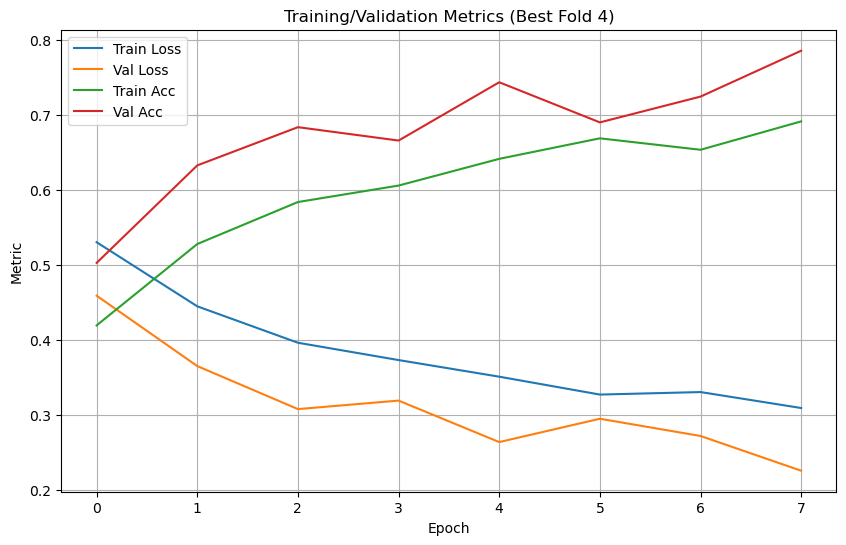

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)

        return img, label


# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

dataset = MultiLabelDataset(
    "/home/intellisense08/Yehan/project_dir/Real_World_data/Data_root/Lib_keells_Aug_left_right/",
    transform=transform
)

# -------------------- Model Loader --------------------
def get_model(pretrained="synthetic"):
    if pretrained == "imagenet":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")
    elif pretrained == "synthetic":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
        ckpt_path = "/home/intellisense08/Yehan/project_dir/Webots/trained_models/MobilenetV2/mobilenetv2_synthetic.pth"
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last conv block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # Replace last linear layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 3)

    return model


# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None
best_fold_idx = None  # <<< --- track best fold index --- >>>

# Early stopping config
patience = 3
min_delta = 1e-4

save_root = "/home/intellisense08/Yehan/project_dir/Real_World_data/trained_models/Lib_keells_Aug_left_right/session2/syn/mb"  # <<< --- base path --- >>>
os.makedirs(save_root, exist_ok=True)

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold + 1}/{k_folds}")
    print("-" * 20)

    train_sub = Subset(dataset, train_ids)
    val_sub = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=16)

    model = get_model(pretrained="synthetic")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # Validation
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch + 1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Early stopping
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold + 1} Best Val Accuracy: {best_val_acc:.4f}")

    # <<< --- save each fold model --- >>>
    fold_dir = os.path.join(save_root, f"fold_{fold + 1}")
    os.makedirs(fold_dir, exist_ok=True)
    fold_model_path = os.path.join(fold_dir, f"mobilenetv2_fold{fold + 1}_best.pth")
    torch.save(best_fold_wts, fold_model_path)
    print(f" Saved best model for Fold {fold + 1} at: {fold_model_path}")

    # track best overall fold
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)
        best_fold_history = deepcopy(history)
        best_fold_idx = fold + 1

# -------------------- Summary --------------------
print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f} (Fold {best_fold_idx})")

# <<< --- Save best overall model --- >>>
best_model_path = os.path.join(save_root, f"mobilenetv2_best_overall_fold{best_fold_idx}.pth")
torch.save(best_model_wts, best_model_path)
print(f" Best overall model saved to: {best_model_path}")

# -------------------- Plot Best Fold History --------------------
plt.figure(figsize=(10, 6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title(f"Training/Validation Metrics (Best Fold {best_fold_idx})")
plt.legend()
plt.grid(True)
plt.show()


weights_from_the_scratch